# Food101 with Efficientnetb0 fine-tuned

## Create some helper functions

In [ ]:
# Create TensorBoard callback function
import datetime
def create_tensorboard_callback(dir_name, experiment_name):

  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
# Plot Loss curves function
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## Use TensorFlow Datasets to Download Data

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print('food101' in datasets_list) # is our target dataset in the list of TFDS dataset?

True


In [ ]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=False,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

## Exploring the Food101 data from TensorFlow Datasets

In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10], len(class_names)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 101)

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # sample are in format (image_tensor, label)

In [ ]:
# What does one sample of training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# Output info about training sample
for image, label in train_one_sample:
  print(f"""
  Image Shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image Shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
  


In [ ]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [ ]:
# what are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image), tf.__version__

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>,
 '2.7.0')

### Plot an image from TensorFlow Datasets

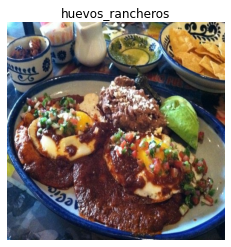

In [ ]:
# Plot an image tensor 
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

## Create preprocessing functions for our data

In [ ]:
# Make a function for preprocessing images
def preprocessing_img(image, label, img_shape=224):
  """
  Converts image datatype from `uint8` -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # resize target image
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single image and check the outputs
preprocessed_img = preprocessing_img(image, label)[0]
print(f'Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}')
print(f'Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}')

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>
Image after preprocessing:
 [[[230.65816  253.64285  251.      ]
  [222.99998  254.97449  252.19388 ]
  [207.06633  255.       250.36734 ]
  ...
  [140.66287  129.52519  121.22428 ]
  [121.14268  115.265144 116.95397 ]
  [ 83.95363   83.08119   89.63737 ]]

 [[221.47449  254.37755  253.33163 ]
  [214.5102   255.       253.92348 ]
  [198.41327  254.58673  251.96939 ]
  ...
  [208.66318  195.82143  173.40823 ]
  [197.03056  190.1071   174.83162 ]
  [175.54036  171.6169   161.21384 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

In [ ]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Create modelling callbacks

In [ ]:
# Create ModelCheckpoint callback to save model's progress during training
checkpoint_path = 'model_checkpoint/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='vall_acc',
                                                      save_best_only=True,
                                                      save_weight_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

## Setup mixed precision training

In [ ]:
# Turn on mixed precision training 
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model 
inputs = layers.Input(shape=input_shape, name='input_layer')
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies 

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]: # Check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Fit the feature extraction model

In [ ]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name='training_logs',
                                                                                            experiment_name='efficientb0_101_classes_all_data_feature_extract'),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_feature_extract/20211118-050425


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8201 - accuracy: 0.5598WARNING:tensorflow:Can save best model only with vall_acc available, skipping.


2368/2368 [==============================] - 307s 110ms/step - loss: 1.8201 - accuracy: 0.5598 - val_loss: 1.2265 - val_accuracy: 0.6833
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2929 - accuracy: 0.6672WARNING:tensorflow:Can save best model only with vall_acc available, skipping.


2368/2368 [==============================] - 251s 105ms/step - loss: 1.2928 - accuracy: 0.6672 - val_loss: 1.1363 - val_accuracy: 0.6981
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1429 - accuracy: 0.7022WARNING:tensorflow:Can save best model only with vall_acc available, skipping.


2368/2368 [==============================] - 261s 109ms/step - loss: 1.1429 - accuracy: 0.7022 - val_loss: 1.0982 - val_accuracy: 0.7039


In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 83s 105ms/step - loss: 1.0891 - accuracy: 0.7067


[1.0891268253326416, 0.7066534757614136]

## Fine-tune model

In [ ]:
# Create fine-tuning model
fine_tune_model = model
fine_tune_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Set all layer trainable to True
for layer in fine_tune_model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in fine_tune_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
fine_tune_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = fine_tune_model.fit(train_data,
                                                        epochs=5, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20211118-052520
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - ETA: 0s - loss: 0.9221 - accuracy: 0.7532INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 1246s 512ms/step - loss: 0.9221 - accuracy: 0.7532 - val_loss: 0.7891 - val_accuracy: 0.7786 - lr: 1.0000e-04
Epoch 2/5
2368/2368 [==============================] - 1139s 480ms/step - loss: 0.5790 - accuracy: 0.8392 - val_loss: 0.8069 - val_accuracy: 0.7826 - lr: 1.0000e-04
Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.9059
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 1131s 476ms/step - loss: 0.3318 - accuracy: 0.9059 - val_loss: 0.8609 - val_accuracy: 0.7791 - lr: 1.0000e-04
Epoch 4/5
2368/2368 [==============================] - 1134s 478ms/step - loss: 0.0858 - accuracy: 0.9792 - val_loss: 0.9439 - val_accuracy: 0.7998 - lr: 2.0000e-05


In [ ]:
# Evaluate model on whole test dataset
results_fine_tuned_model = fine_tune_model.evaluate(test_data)
results_fine_tuned_model

790/790 [==============================] - 75s 95ms/step - loss: 0.9426 - accuracy: 0.7987


[0.9425762891769409, 0.7987326979637146]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save our model fine-tuning model
fine_tune_model.save('/content/drive/MyDrive/MachineLearningProject3_1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/MachineLearningProject3_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MachineLearningProject3_1/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/MachineLearningProject3_1')

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 123s 108ms/step - loss: 0.9426 - accuracy: 0.7987


[0.9425760507583618, 0.7987326979637146]

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 79s 100ms/step - loss: 0.9426 - accuracy: 0.7987


[0.9425755143165588, 0.7987326979637146]

In [ ]:
results_fine_tuned_model

## Making predictions with our trained model

In [ ]:
constant_test_data = test_data

In [ ]:
# Make predictions with model
preds_probs = loaded_model.predict(constant_test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 75s 95ms/step


In [ ]:
len(constant_test_data)

790

In [ ]:
# How many predictions are these?
len(preds_probs)

25250

In [ ]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[1.3082786e-04, 3.3822481e-13, 2.1466540e-10, ..., 4.0907981e-08,
        1.6553217e-11, 6.3760410e-05],
       [7.2478307e-10, 3.8853277e-13, 2.6249899e-10, ..., 3.0560470e-12,
        3.5471945e-08, 3.4827856e-13],
       [1.3097232e-11, 1.1028975e-11, 4.2763978e-13, ..., 8.5046320e-13,
        5.4286516e-11, 4.3437413e-13],
       ...,
       [1.6018567e-10, 3.4013553e-16, 8.9103538e-15, ..., 1.1506638e-15,
        5.2381263e-15, 7.2310105e-14],
       [2.1586895e-13, 9.3375735e-15, 3.0142057e-14, ..., 3.2405770e-13,
        7.9963939e-07, 7.0483708e-15],
       [1.3824065e-01, 3.1015541e-11, 4.0451892e-11, ..., 3.3697219e-05,
        4.0512830e-14, 8.5955870e-01]], dtype=float32)

In [ ]:
# What's does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([1.30827859e-04, 3.38224809e-13, 2.14665397e-10, 6.97966397e-14,
        2.38113018e-09, 2.66034417e-12, 7.66566105e-14, 1.07940552e-10,
        6.78725992e-05, 3.04002334e-08, 4.56361562e-08, 1.04777162e-13,
        2.87219137e-09, 5.22278128e-07, 7.76297142e-08, 2.38471721e-12,
        2.29127836e-05, 9.47713943e-06, 4.12662848e-15, 6.27344265e-09,
        7.47235864e-15, 1.62134722e-06, 1.19550657e-06, 8.89763374e-10,
        5.68806668e-11, 1.97699994e-12, 1.81801536e-11, 3.05283288e-06,
        3.27325667e-10, 9.99290109e-01, 6.51353548e-06, 4.15521910e-08,
        2.87651825e-12, 2.78050046e-17, 4.84044904e-06, 6.76492215e-14,
        2.52026773e-08, 2.31134708e-12, 4.97766492e-15, 3.31085203e-12,
        1.95749517e-13, 1.59766094e-13, 7.20982644e-06, 4.04560439e-17,
        1.44640409e-12, 7.81208873e-05, 3.38224809e-13, 3.52969259e-15,
        2.38471721e-12, 1.74207204e-09, 3.46974294e-12, 4.74257656e-12,
        1.82842608e-12, 1.30749775e-08, 2.40198612e-16, 1.800078

In [ ]:
# What's does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([1.30827859e-04, 3.38224809e-13, 2.14665397e-10, 6.97966397e-14,
        2.38113018e-09, 2.66034417e-12, 7.66566105e-14, 1.07940552e-10,
        6.78725992e-05, 3.04002334e-08, 4.56361562e-08, 1.04777162e-13,
        2.87219137e-09, 5.22278128e-07, 7.76297142e-08, 2.38471721e-12,
        2.29127836e-05, 9.47713943e-06, 4.12662848e-15, 6.27344265e-09,
        7.47235864e-15, 1.62134722e-06, 1.19550657e-06, 8.89763374e-10,
        5.68806668e-11, 1.97699994e-12, 1.81801536e-11, 3.05283288e-06,
        3.27325667e-10, 9.99290109e-01, 6.51353548e-06, 4.15521910e-08,
        2.87651825e-12, 2.78050046e-17, 4.84044904e-06, 6.76492215e-14,
        2.52026773e-08, 2.31134708e-12, 4.97766492e-15, 3.31085203e-12,
        1.95749517e-13, 1.59766094e-13, 7.20982644e-06, 4.04560439e-17,
        1.44640409e-12, 7.81208873e-05, 3.38224809e-13, 3.52969259e-15,
        2.38471721e-12, 1.74207204e-09, 3.46974294e-12, 4.74257656e-12,
        1.82842608e-12, 1.30749775e-08, 2.40198612e-16, 1.800078

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

In [ ]:
# array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

25250

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in constant_test_data.unbatch():
  y_labels.append(labels.numpy()) # currently test labels look like: [0, 0, 0, 1, .... , 0, 0] we want the index value
y_labels[:10] # look at the first 10

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

## Evaluating model's predictions

In [ ]:
loaded_model_results

[0.9425755143165588, 0.7987326979637146]

In [ ]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.7987326732673268

In [ ]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(loaded_model_results[1], sklearn_accuracy)

True

### Confusion Metrix

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

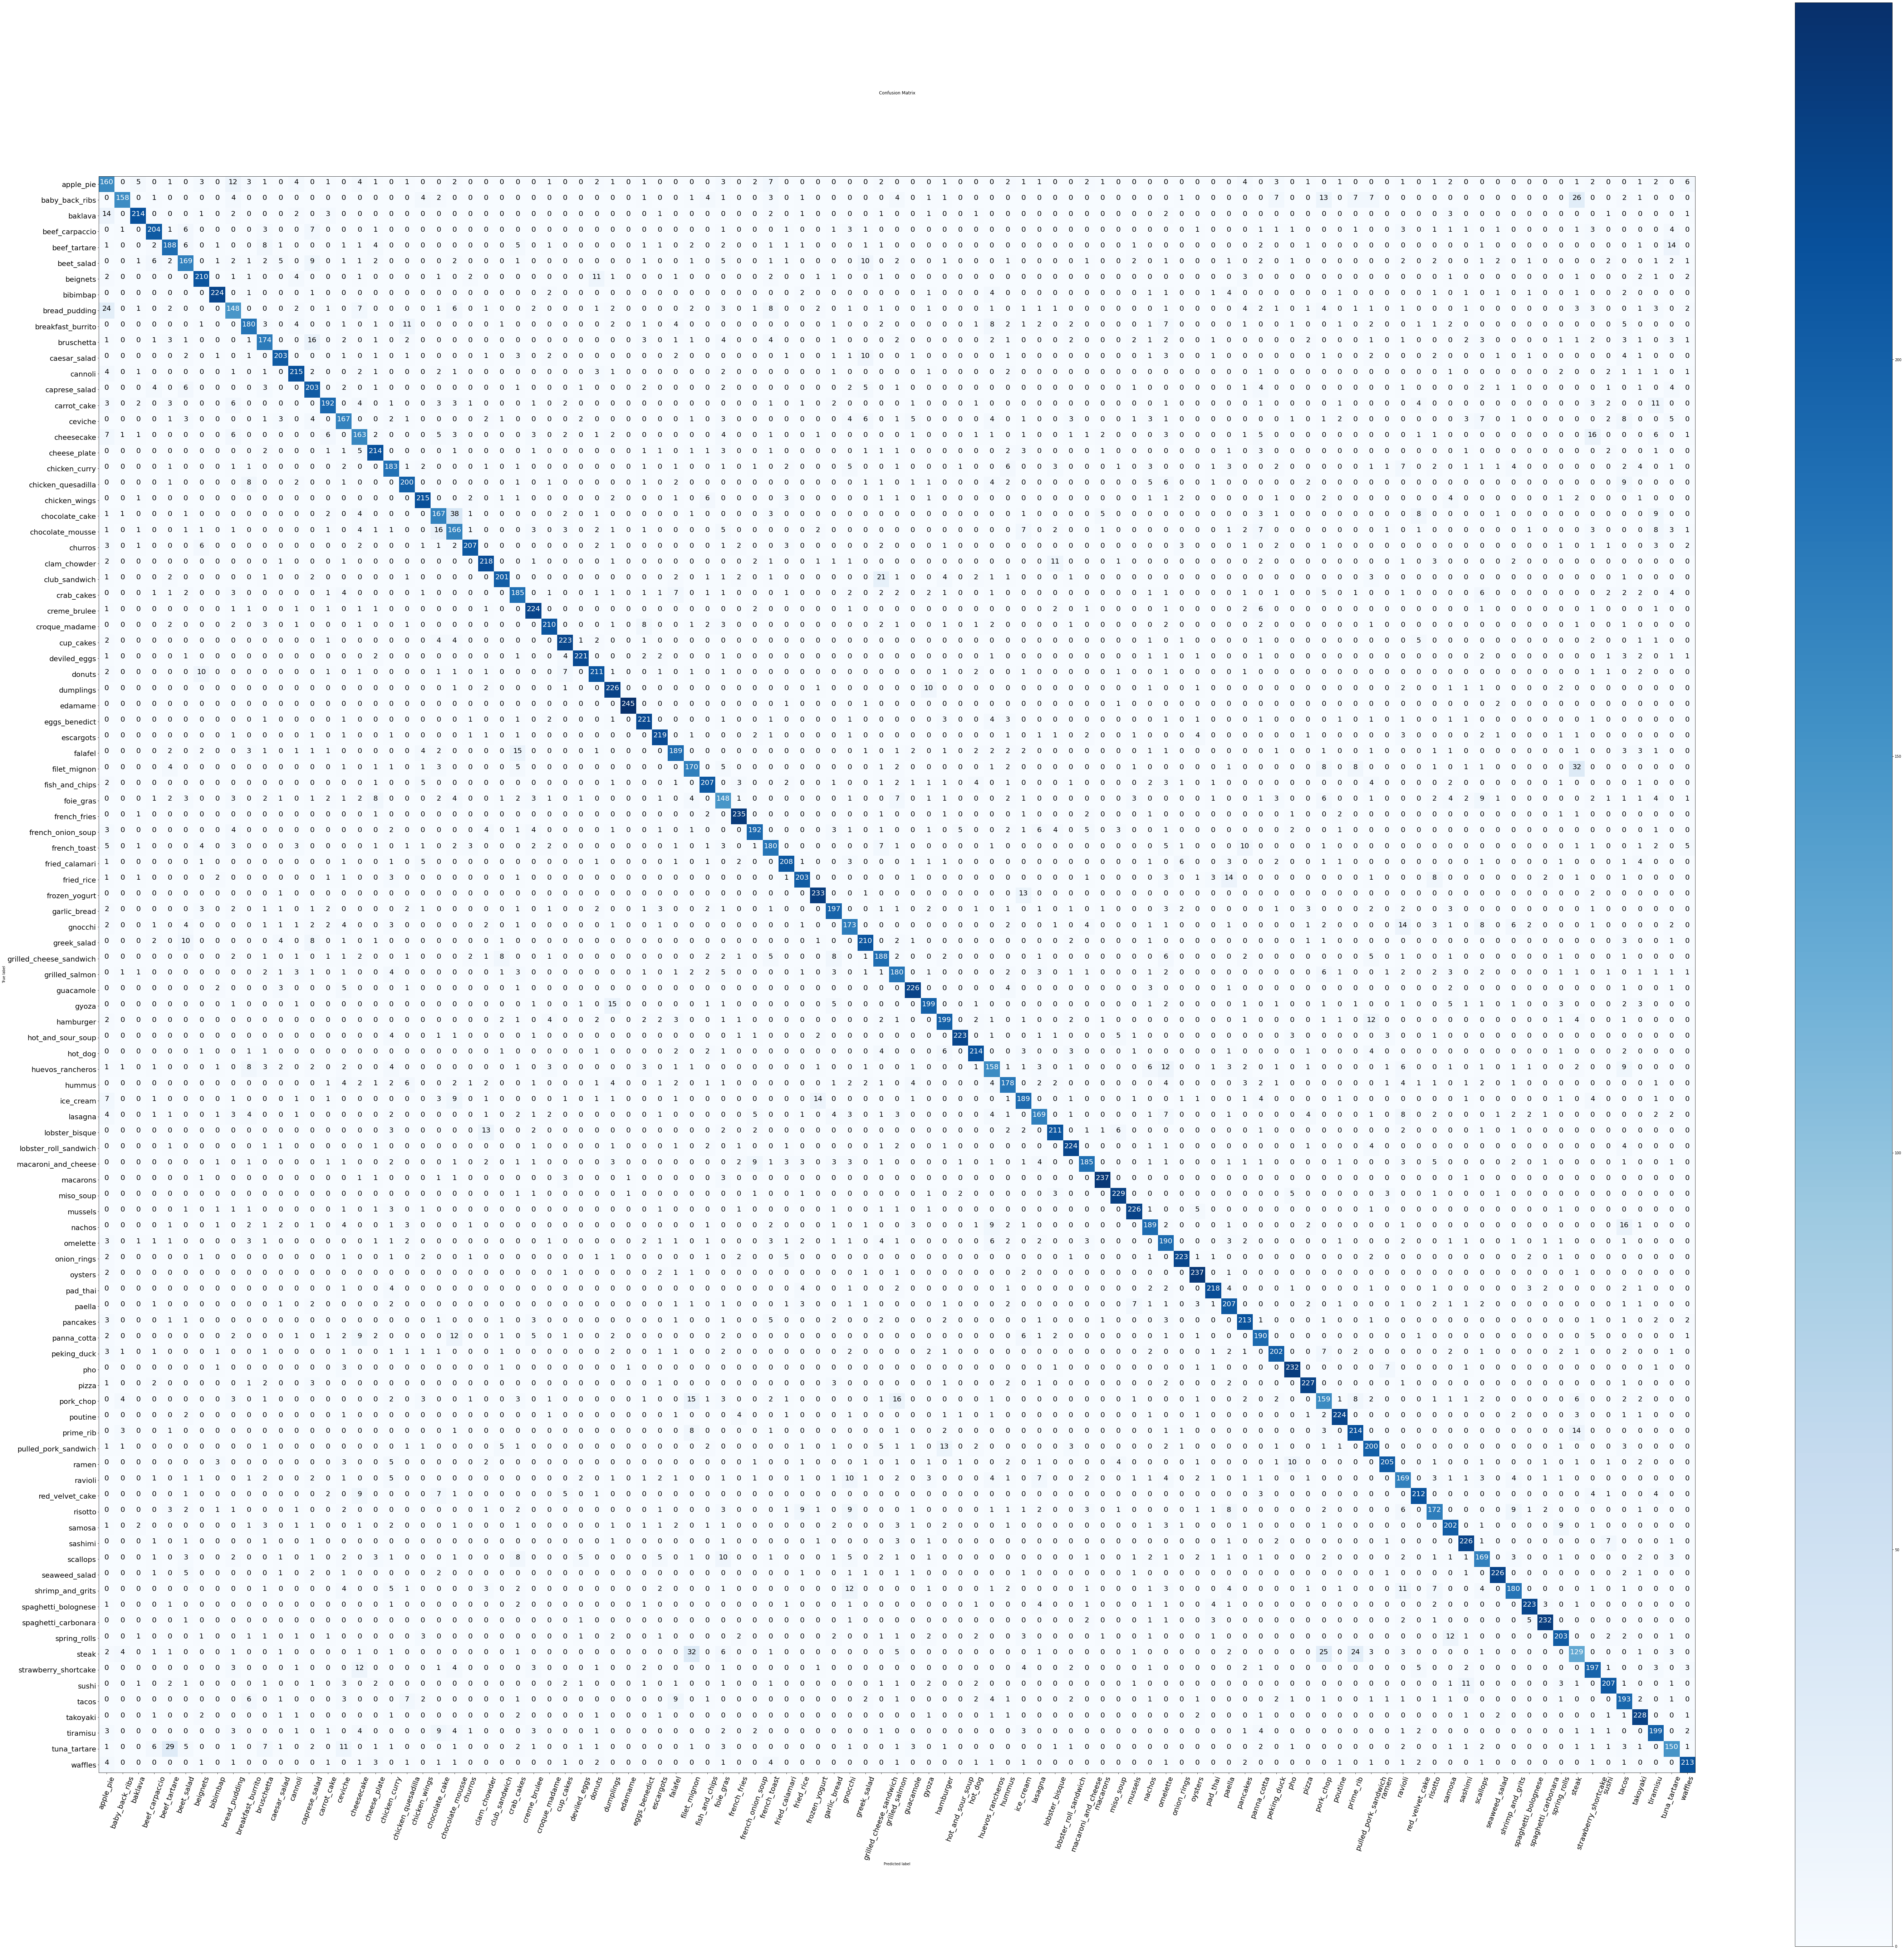

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.55      0.64      0.59       250
           1       0.90      0.63      0.74       250
           2       0.90      0.86      0.88       250
           3       0.84      0.82      0.83       250
           4       0.73      0.75      0.74       250
           5       0.71      0.68      0.69       250
           6       0.84      0.84      0.84       250
           7       0.93      0.90      0.91       250
           8       0.65      0.59      0.62       250
           9       0.78      0.72      0.75       250
          10       0.73      0.70      0.71       250
          11       0.86      0.81      0.83       250
          12       0.85      0.86      0.85       250
          13       0.73      0.81      0.77       250
          14       0.84      0.77      0.80       250
          15       0.66      0.67      0.66       250
          16       0.67      0.65      0.66       250
          17       0.82    

In [ ]:
# Get a dictionary of the classificaiton report 
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.5936920222634509,
  'precision': 0.5536332179930796,
  'recall': 0.64,
  'support': 250},
 '1': {'f1-score': 0.7417840375586856,
  'precision': 0.8977272727272727,
  'recall': 0.632,
  'support': 250},
 '10': {'f1-score': 0.7116564417177914,
  'precision': 0.7280334728033473,
  'recall': 0.696,
  'support': 250},
 '100': {'f1-score': 0.8537074148296594,
  'precision': 0.8554216867469879,
  'recall': 0.852,
  'support': 250},
 '11': {'f1-score': 0.8336755646817249,
  'precision': 0.8565400843881856,
  'recall': 0.812,
  'support': 250},
 '12': {'f1-score': 0.8531746031746033,
  'precision': 0.8464566929133859,
  'recall': 0.86,
  'support': 250},
 '13': {'f1-score': 0.7703984819734345,
  'precision': 0.7328519855595668,
  'recall': 0.812,
  'support': 250},
 '14': {'f1-score': 0.8016701461377871,
  'precision': 0.8384279475982532,
  'recall': 0.768,
  'support': 250},
 '15': {'f1-score': 0.6640159045725647,
  'precision': 0.6600790513833992,
  'recall': 0.668,
  'su

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == 'accuracy': # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v['f1-score']

class_f1_scores

{'apple_pie': 0.5936920222634509,
 'baby_back_ribs': 0.7417840375586856,
 'baklava': 0.8788501026694044,
 'beef_carpaccio': 0.8275862068965517,
 'beef_tartare': 0.7401574803149605,
 'beet_salad': 0.6912065439672801,
 'beignets': 0.8399999999999999,
 'bibimbap': 0.9105691056910571,
 'bread_pudding': 0.6192468619246863,
 'breakfast_burrito': 0.7484407484407484,
 'bruschetta': 0.7116564417177914,
 'caesar_salad': 0.8336755646817249,
 'cannoli': 0.8531746031746033,
 'caprese_salad': 0.7703984819734345,
 'carrot_cake': 0.8016701461377871,
 'ceviche': 0.6640159045725647,
 'cheese_plate': 0.8359375000000001,
 'cheesecake': 0.6585858585858585,
 'chicken_curry': 0.7233201581027667,
 'chicken_quesadilla': 0.8064516129032258,
 'chicken_wings': 0.8548707753479126,
 'chocolate_cake': 0.6858316221765913,
 'chocolate_mousse': 0.6311787072243346,
 'churros': 0.8697478991596639,
 'clam_chowder': 0.8549019607843137,
 'club_sandwich': 0.8427672955974843,
 'crab_cakes': 0.72265625,
 'creme_brulee': 0.8648

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                          'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)

In [ ]:
f1_scores

,class_names,f1-score
33,edamame,0.983936
63,macarons,0.944223
91,spaghetti_carbonara,0.935484
40,french_fries,0.921569
54,hot_and_sour_soup,0.921488
...,...,...
77,pork_chop,0.624754
8,bread_pudding,0.619247
0,apple_pie,0.593692
39,foie_gras,0.579256


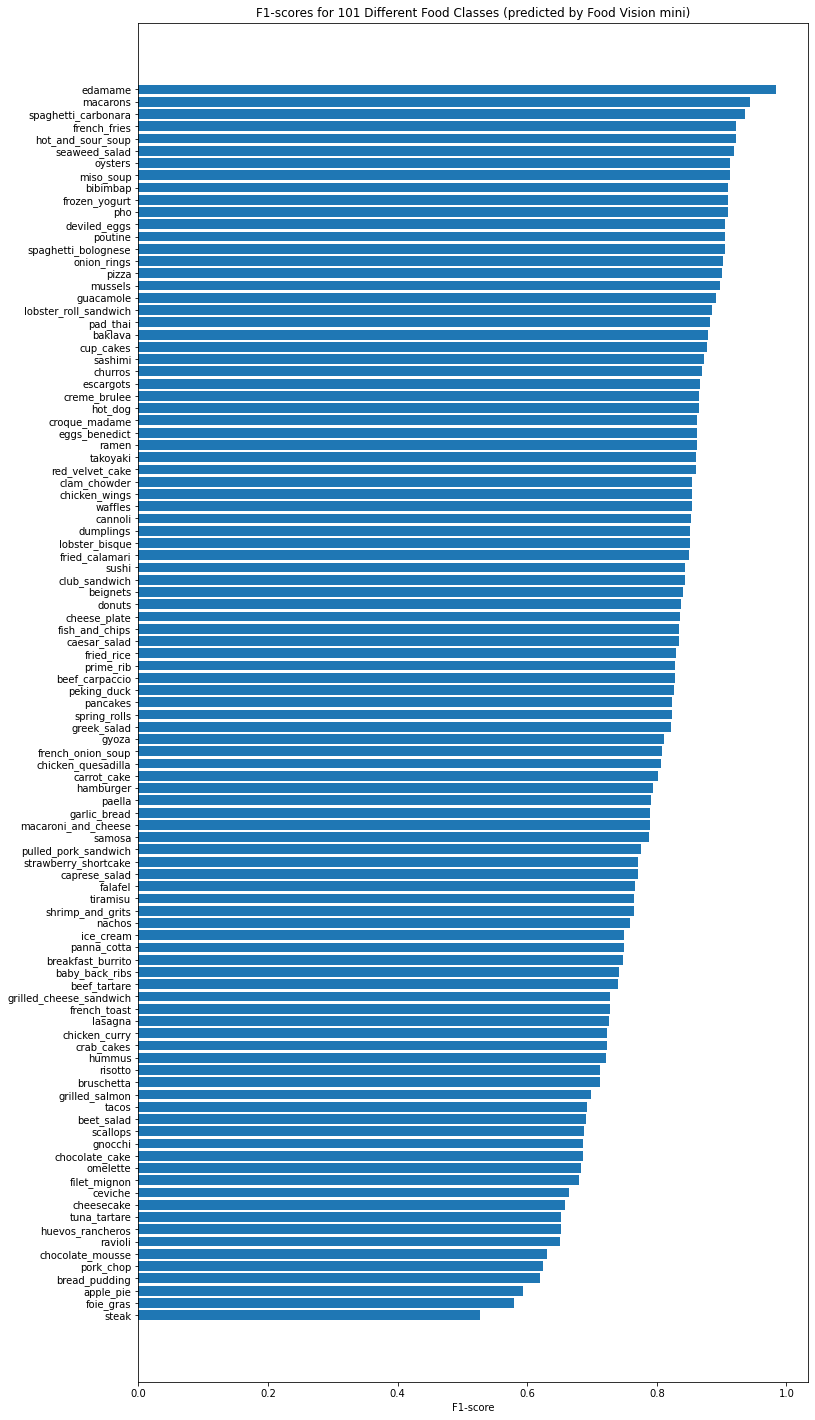

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1-score')
ax.set_title('F1-scores for 101 Different Food Classes (predicted by Food Vision mini)')
ax.invert_yaxis(); # reverse the order of our plot